In [ ]:
#installer
%pip install tensorflow

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# Import
data_path = 'input'
train_dir = Path(data_path + '/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

test_dir = Path(data_path + '/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(data_path + 'validation')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

def process_imgs(filepath):
    labels = [Path(filepath[i]).parent.name for i in range(len(filepath))]
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    dt = pd.concat([filepath, labels], axis=1)

    # Shuffle 
    dt = dt.sample(frac=1).reset_index(drop = True)
    
    return dt

train_dt = process_imgs(train_filepaths)
test_dt = process_imgs(test_filepaths)
val_dt = process_imgs(val_filepaths)

C:\Users\balog\AppData\Local\Temp\ipykernel_67884\2831523222.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#Check imports
print('-- Training set --\n')
print(f'Number of pictures: {train_dt.shape[0]}\n')
print(f'Number of different labels: {len(train_dt.Label.unique())}\n')
print(f'Labels: {train_dt.Label.unique()}')

train_dt.head(5)

-- Training set --

Number of pictures: 2855

Number of different labels: 36

Labels: ['jalepeno' 'spinach' 'orange' 'corn' 'paprika' 'lettuce' 'banana'
 'cauliflower' 'chilli pepper' 'onion' 'garlic' 'tomato' 'eggplant'
 'watermelon' 'cabbage' 'mango' 'grapes' 'lemon' 'turnip' 'pear' 'kiwi'
 'peas' 'beetroot' 'carrot' 'bell pepper' 'pomegranate' 'sweetpotato'
 'soy beans' 'cucumber' 'raddish' 'apple' 'pineapple' 'sweetcorn' 'potato'
 'capsicum' 'ginger']


,Filepath,Label
0,input\train\jalepeno\Image_89.jpg,jalepeno
1,input\train\spinach\Image_20.jpg,spinach
2,input\train\spinach\Image_24.jpg,spinach
3,input\train\orange\Image_72.jpg,orange
4,input\train\corn\Image_23.jpg,corn


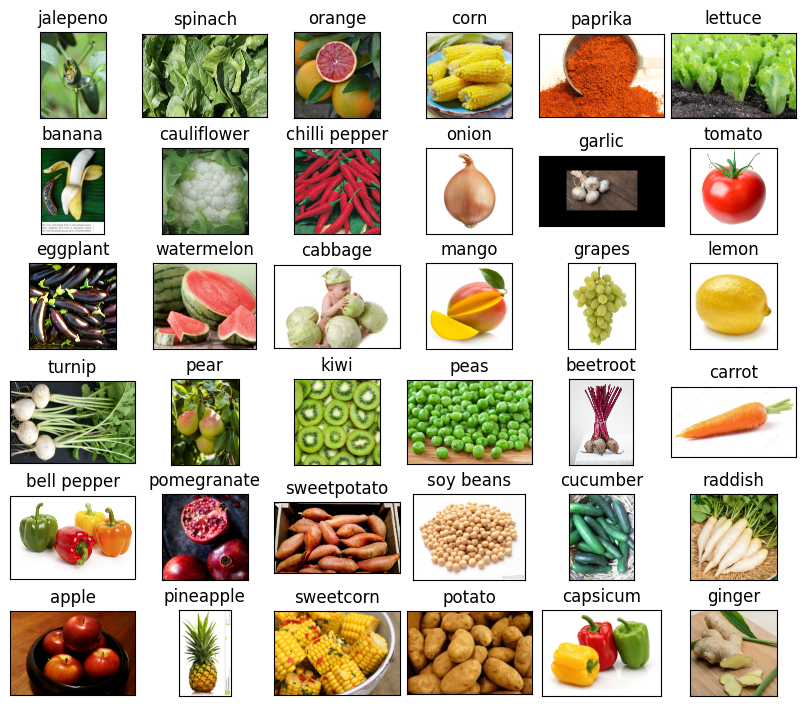

In [ ]:
#filepath and label
dt_unique = train_dt.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(dt_unique.Filepath[i]))
    ax.set_title(dt_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_dt,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_dt,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_dt,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


In [6]:
#Load pretrained neural network, MobileNetV2: convolutional neural network that is 53 layers deep
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
#Training
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.3413 - loss: 2.6088 - val_accuracy: 0.8588 - val_loss: 0.4756
Epoch 2/5
90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.8022 - loss: 0.6356 - val_accuracy: 0.9000 - val_loss: 0.2972
Epoch 3/5
 9/90 ━━━━━━━━━━━━━━━━━━━━ 1:28 1s/step - accuracy: 0.8625 - loss: 0.3612

In [ ]:
#Save model
model.save('./model/model.keras')

In [ ]:
#A
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

#Test predictions
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Metrics
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()